In [1]:
import math
import numpy as np
import torch
import torch.utils.checkpoint
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm.auto import tqdm

from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.utils import match_dim_with_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [2]:
batch_size = 512

transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose(transform_list)
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,          
    pin_memory=True,
    persistent_workers=False,
)

batch = next(iter(train_dataloader))
print(batch[0].shape)  # torch.Size([256, 1, 28, 28])

torch.Size([512, 1, 28, 28])


In [3]:
model_type = "unet"
from rectified_flow.models.enhanced_mlp import VarMLP
from rectified_flow.models.utils import EMAModel
from rectified_flow.models.unet import SongUNet, SongUNetConfig

flow_model = SongUNet.from_pretrained("/scratch/10992/liaorunlong93/random_flow_toys/checkpoints/flow_mnist_unet_unconditional", use_ema=True).to(device)

Model loaded from /scratch/10992/liaorunlong93/random_flow_toys/checkpoints/flow_mnist_unet_unconditional/unet_ema.pt


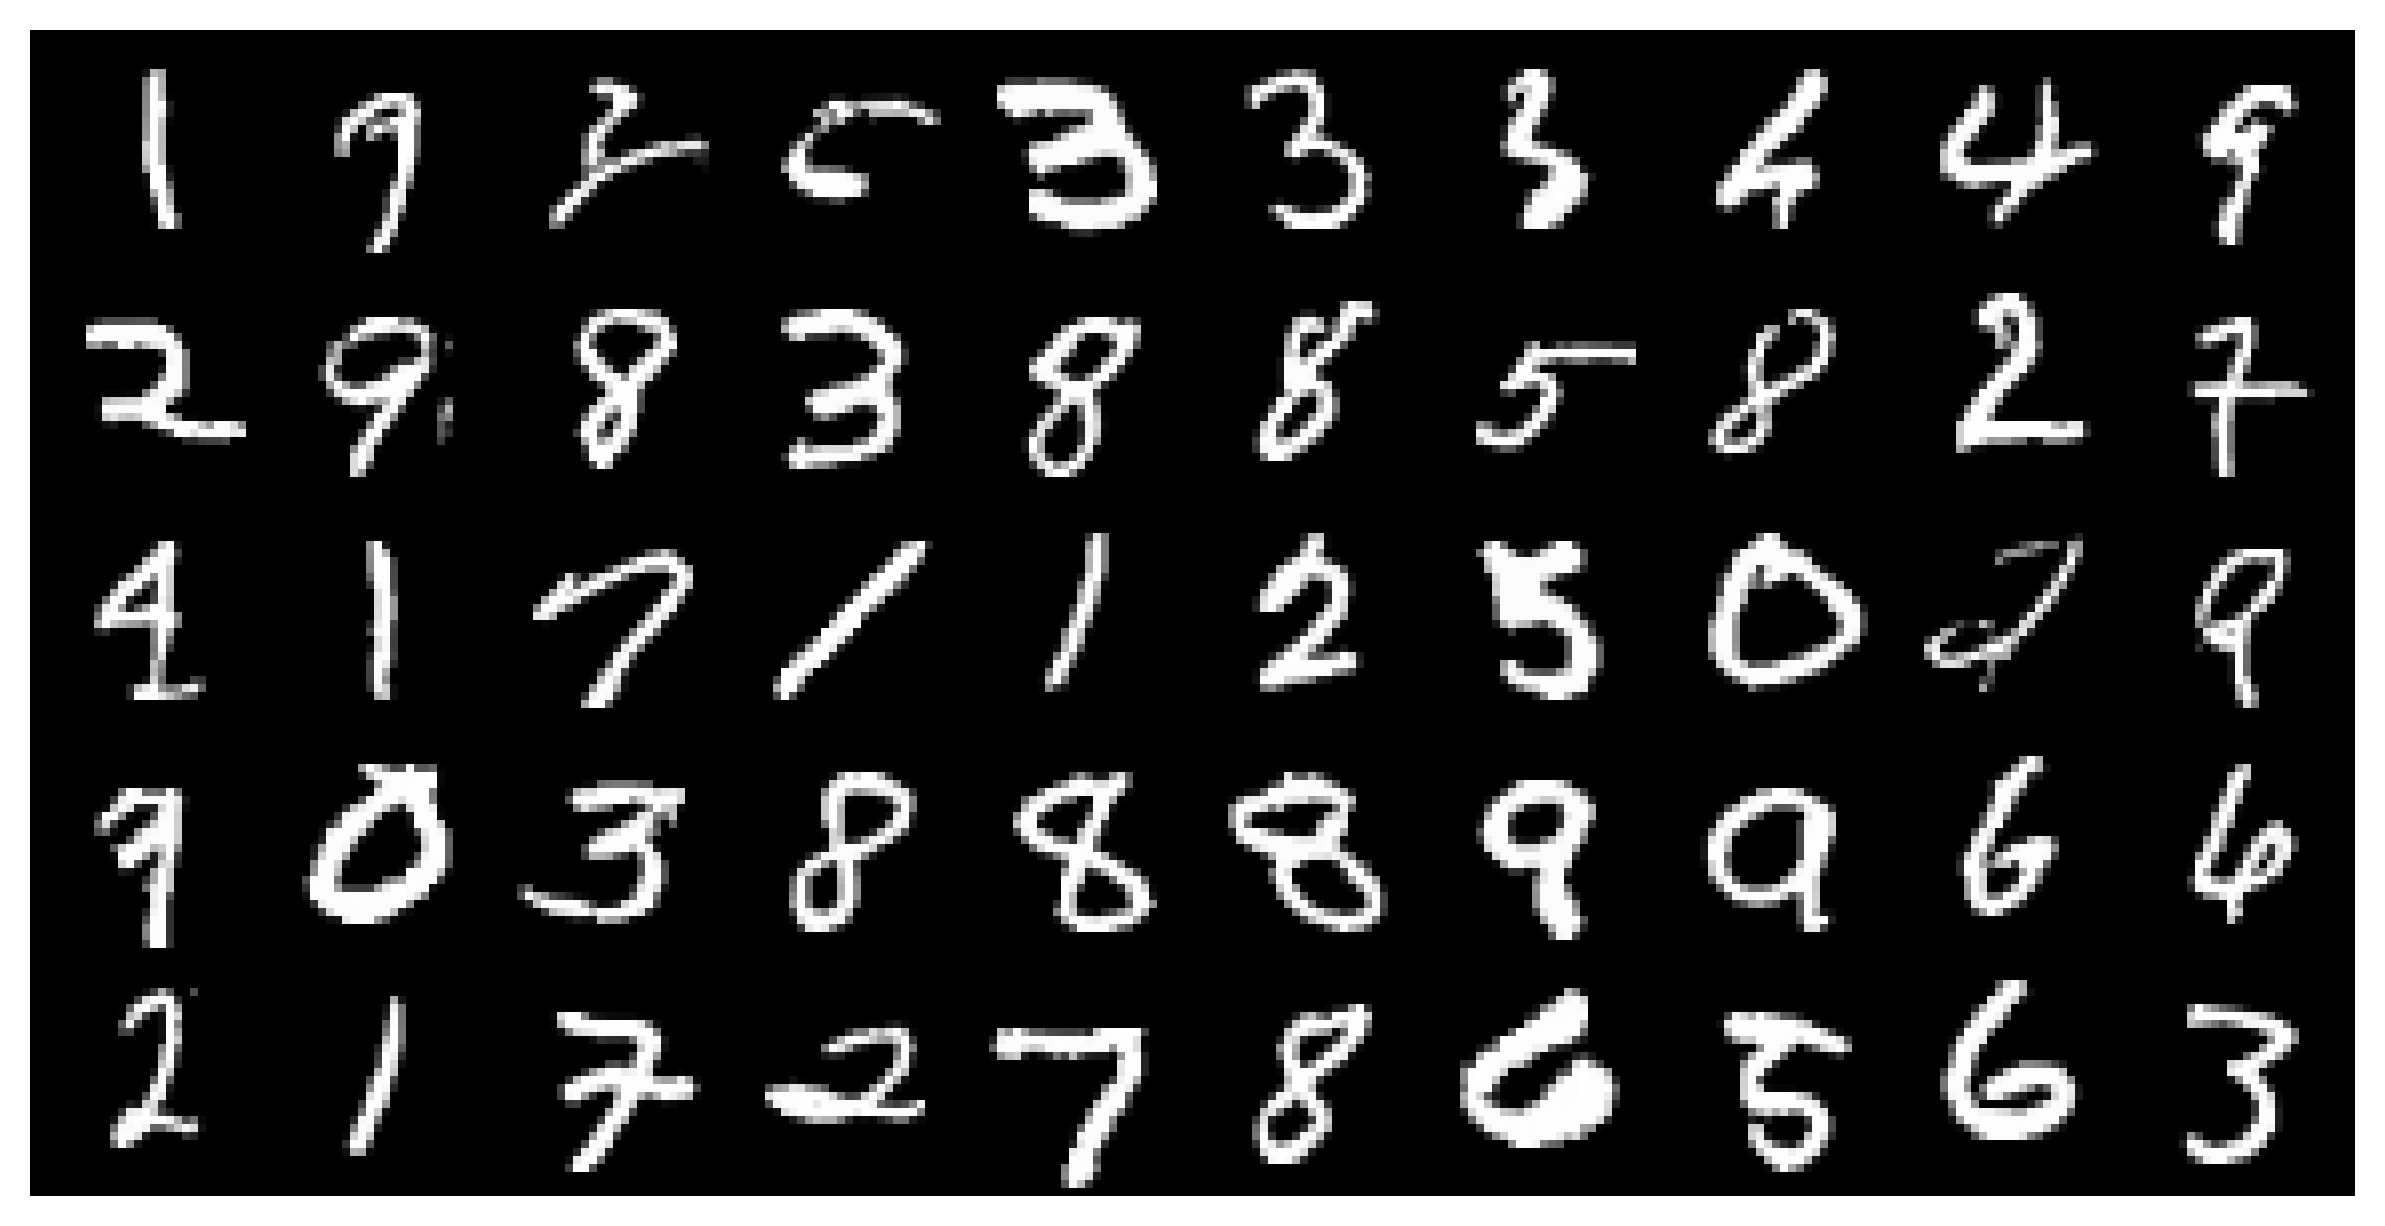

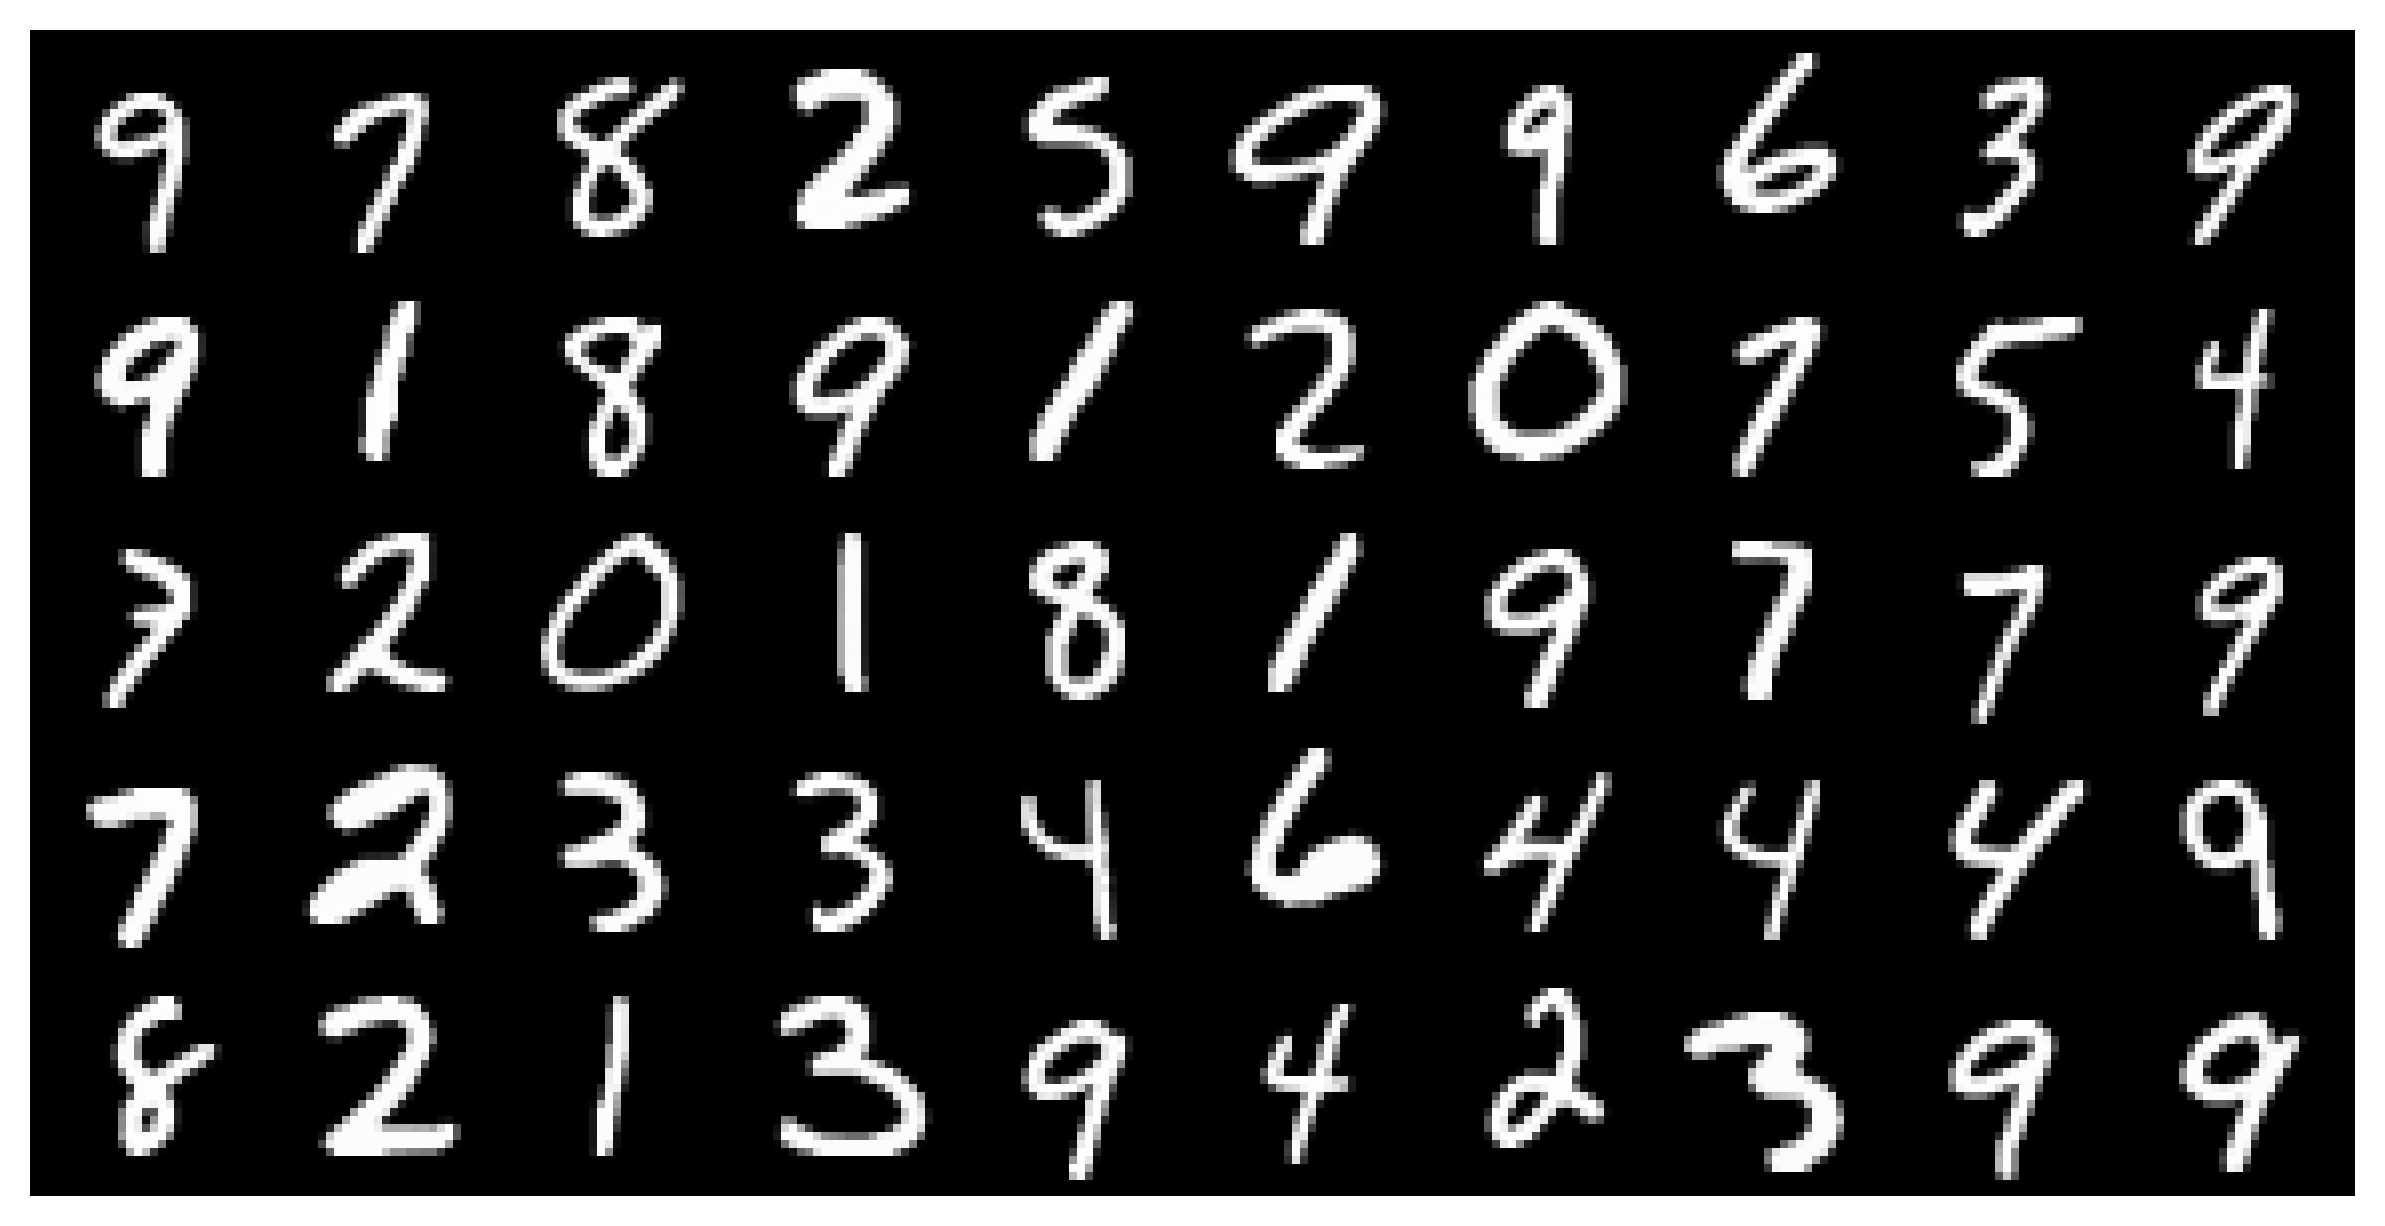

In [4]:
from rectified_flow.samplers import EulerSampler, SDESampler
from rectified_flow.utils import plot_cifar_results

rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=flow_model,
    device=device,
)

sampler = EulerSampler(rectified_flow=rf, num_samples=50, num_steps=200)
rf_samples = sampler.sample_loop().trajectories[-1]

sde_sampler = SDESampler(rectified_flow=rf, num_samples=50, num_steps=100, noise_decay_rate=0.0, noise_scale=50.0)
rf_sde_samples = sde_sampler.sample_loop().trajectories[-1]

plot_cifar_results(rf_samples)
plot_cifar_results(rf_sde_samples)

## Implement divergence estimation and verify correctness

### Exact Jacobian calculation with autograd

In [5]:
from tqdm import tqdm
from torch.autograd.functional import jacobian

def divergence_exact_manual(v_func, x_t, t):
    device, dtype = x_t.device, x_t.dtype
    B = x_t.shape[0]
    div = torch.empty(B, device=device, dtype=dtype)

    for b in tqdm(range(B), desc="Computing exact divergence"):
        xb = x_t[b:b+1].detach().requires_grad_(True)
        tb = t[b:b+1]

        def f(inp):
            return v_func(inp, tb)

        J = jacobian(f, xb, vectorize=False, create_graph=False)
        D = xb.numel()
        div[b] = J.reshape(D, D).diagonal().sum().to(dtype)
        del J
        
    return div

### Divergence Estimation via the Hutchinson Trick

For a vector field $v(x,t)$ with Jacobian $J(x) = \dfrac{\partial v}{\partial x}$, the divergence is
$$
\operatorname{div} v(x,t) = \operatorname{tr}\, J(x).
$$
Computing $\operatorname{tr} J$ via an explicit Jacobian is expensive. The Hutchinson identity gives an unbiased estimator:
$$
\operatorname{tr} J = \mathbb{E}_{\varepsilon}\!\left[\varepsilon^\top J \varepsilon\right],
$$
where $\varepsilon$ can be Rademacher ($\pm1$ w.p. 1/2) or standard Gaussian. A Monte Carlo estimate is
$$
\widehat{\operatorname{div}}(x,t) = \frac{1}{M}\sum_{i=1}^{M} \varepsilon_i^\top (J\,\varepsilon_i),
$$
which only requires Jacobian–vector products (JVP) or vector–Jacobian products (VJP), avoiding materializing the full Jacobian.

**Implementation notes**
- `eps_dist="rademacher"` often yields slightly lower variance; `"normal"` works too.
- Use forward-mode `jvp` to get $J\varepsilon$, or a single backward (VJP) to get $J^\top \varepsilon$ and then dot with $\varepsilon$.
- Compute per-sample inner products in the batch and average across $M$ probes; `M=1–4` is typically sufficient.
- When using fp16/bf16, accumulate in fp32 for numerical stability.


In [6]:
from torch.func import jvp as jvp_func

def divergence_hutchinson(
    v_func,
    x_t: torch.Tensor,
    t: torch.Tensor,
    n_samples: int = 20,
    eps_dist: str = "rademacher",
    method: str = "vjp",
) -> torch.Tensor:
    device, dtype = x_t.device, x_t.dtype
    B = x_t.shape[0]
    D = x_t.numel() // B

    x_flat = x_t.detach().view(B, D)

    acc_dtype = torch.float32 if dtype in (torch.float16, torch.bfloat16) else dtype
    acc = torch.zeros(B, device=device, dtype=acc_dtype)

    def _sample_eps_flat():
        if eps_dist == "rademacher":
            r = torch.randint(0, 2, (B, D), device=device)
            eps = (r * 2 - 1).to(acc_dtype)
        elif eps_dist == "normal":
            eps = torch.randn((B, D), device=device, dtype=acc_dtype)
        else:
            raise ValueError("eps_dist must be 'rademacher' or 'normal'")
        return eps.to(dtype)

    if method == "jvp":
        def f_flat(inp_flat):
            x4 = inp_flat.view(B, *x_t.shape[1:])
            y4 = v_func(x4, t)
            return y4.view(B, D)

        for _ in range(n_samples):
            eps_flat = _sample_eps_flat()
            _, jvp_out = jvp_func(f_flat, (x_flat,), (eps_flat,), strict=False)  # <-- fix
            acc += (eps_flat * jvp_out).sum(dim=1).to(acc_dtype)

        return (acc / n_samples).to(dtype)

    elif method == "vjp":
        for _ in range(n_samples):
            eps_flat = _sample_eps_flat()
            eps = eps_flat.view_as(x_t)
            x_req = x_t.detach().requires_grad_(True)
            v = v_func(x_req, t)
            s_per_sample = (v * eps).view(B, -1).sum(dim=1)
            gx = torch.autograd.grad(
                s_per_sample.sum(), x_req, create_graph=False, retain_graph=False
            )[0]
            acc += (gx.detach() * eps).view(B, -1).sum(dim=1).to(acc_dtype)
            del x_req, v, gx, eps, eps_flat, s_per_sample

        return (acc / n_samples).to(dtype)

    else:
        raise ValueError("method must be 'jvp' or 'vjp'")

In [7]:
x_1 = batch[0].to(device)[:5]
t = torch.rand(x_1.shape[0], device=device)
x_t = t[:, None, None, None] * x_1 + (1 - t)[:, None, None, None] * torch.randn_like(x_1)

div_exact = divergence_exact_manual(flow_model, x_t, t)
div_approx = divergence_hutchinson(flow_model, x_t, t, n_samples=20, method="vjp")

print("Divergence shape:", div_exact.shape)
print("div exact:", div_exact)
print("div approx:", div_approx)
print("Max absolute error:", (div_exact - div_approx).abs().max().item())

Computing exact divergence: 100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


Divergence shape: torch.Size([5])
div exact: tensor([ -823.9280, -1113.8154, -1150.4958, -5430.1538, -2126.2048],
       device='cuda:0')
div approx: tensor([ -823.6916, -1112.5233, -1150.1118, -5438.4209, -2135.1873],
       device='cuda:0')
Max absolute error: 8.982421875


## log prob estimation with Simultaneous change of variable


$$
\log \rho_t(x^{\mathrm{eval}}) 
= 
\log \rho_0(z_0^{\mathrm{eval}}) 
- 
\int_0^1 \nabla \cdot v_t(z_t^{\mathrm{eval}}) \, \mathrm dt,
$$

where $ \{ z_t^{\mathrm{eval}} \} $ is the solution of 

$$
\dot{z}_t^{\mathrm{eval}} = v_t(z_t^{\mathrm{eval}}), 
\quad \text{with} \quad 
z_1^{\mathrm{eval}} = x^{\mathrm{eval}}.
$$



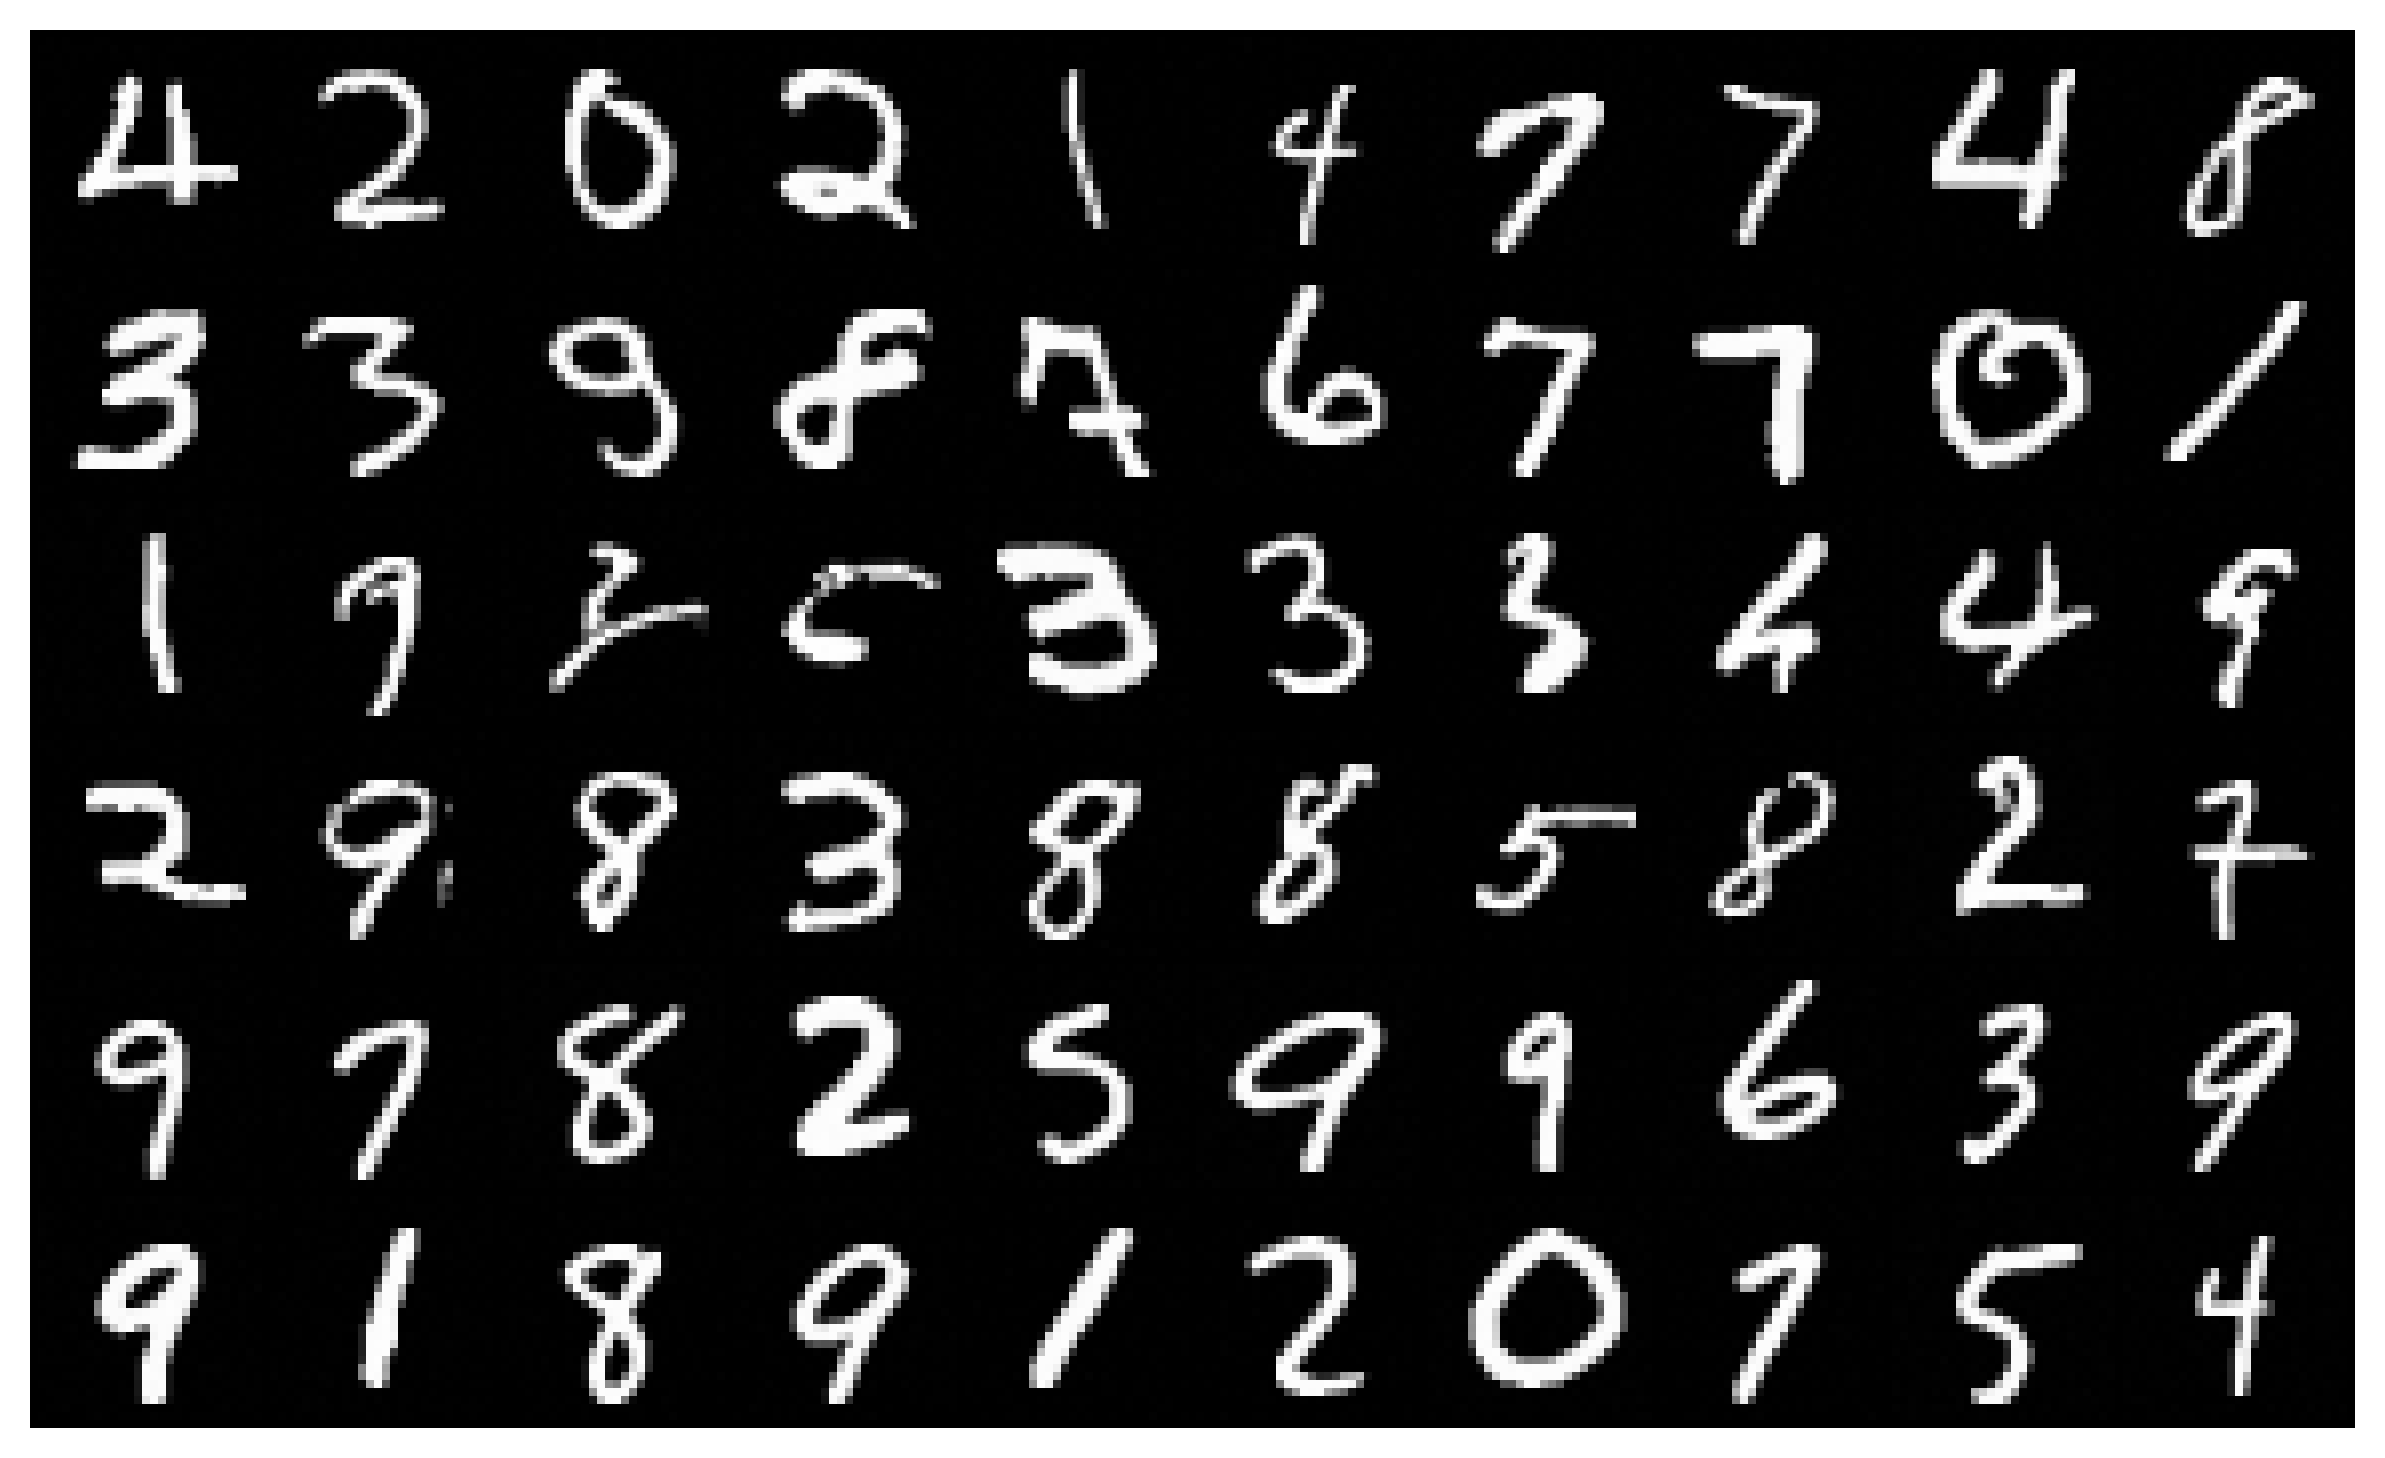

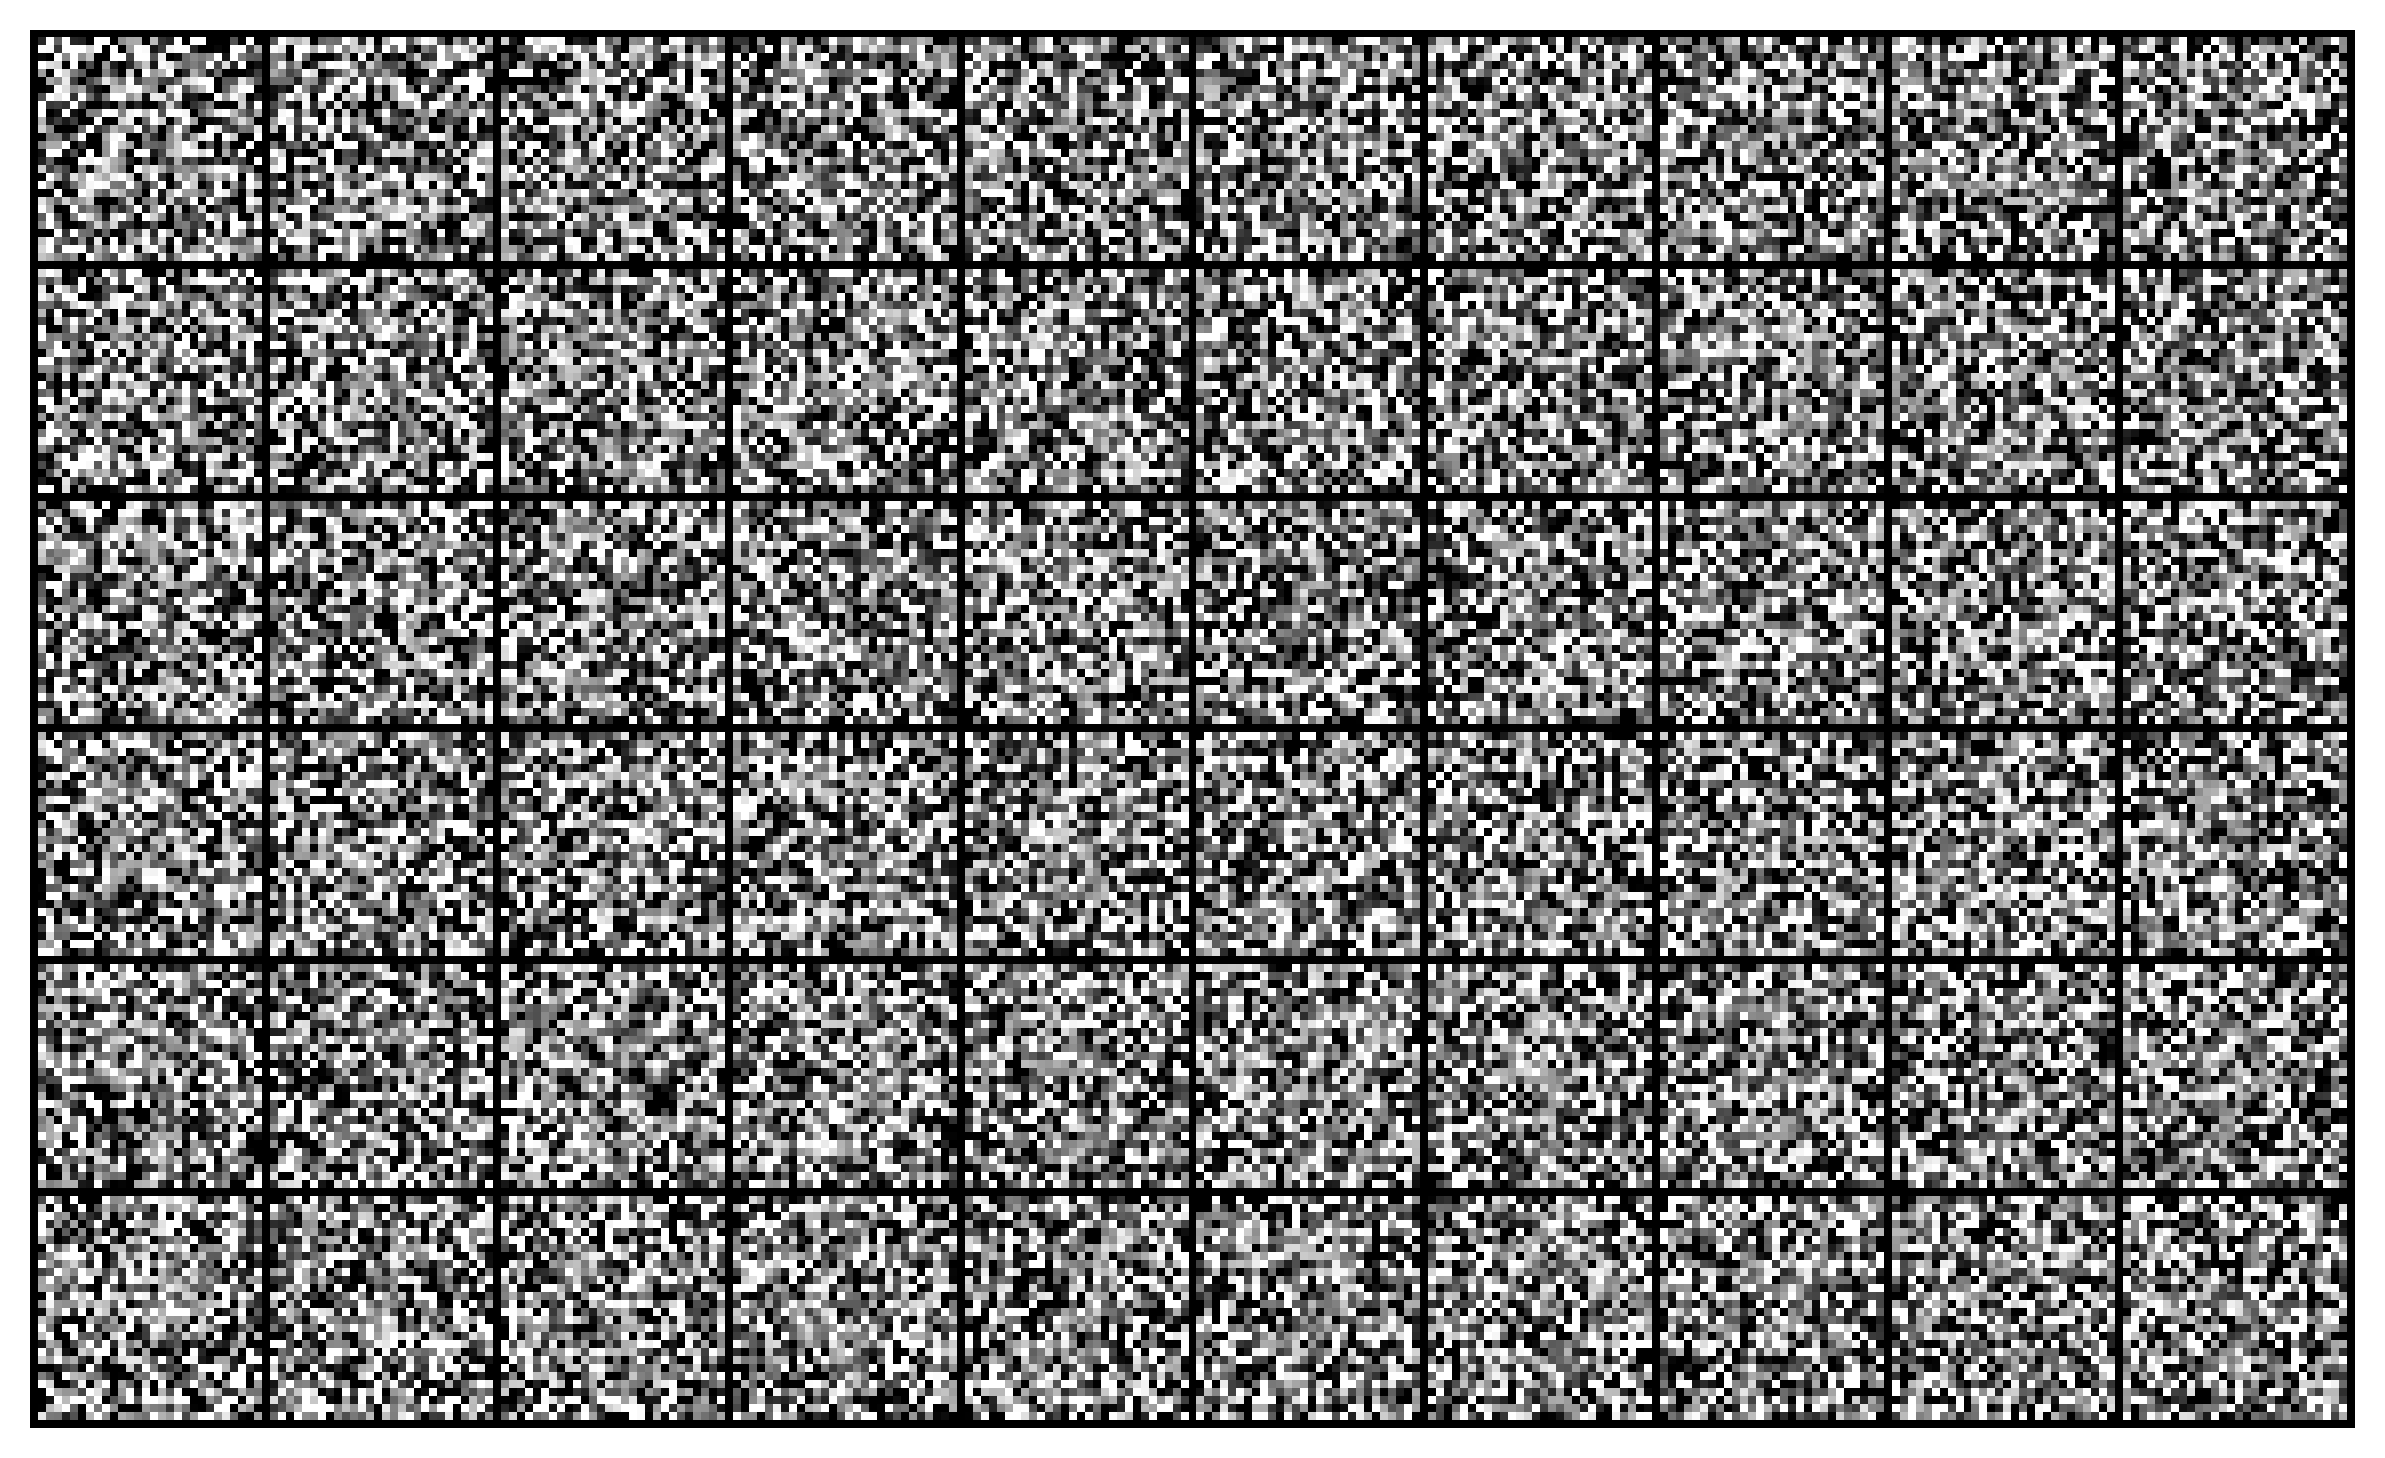

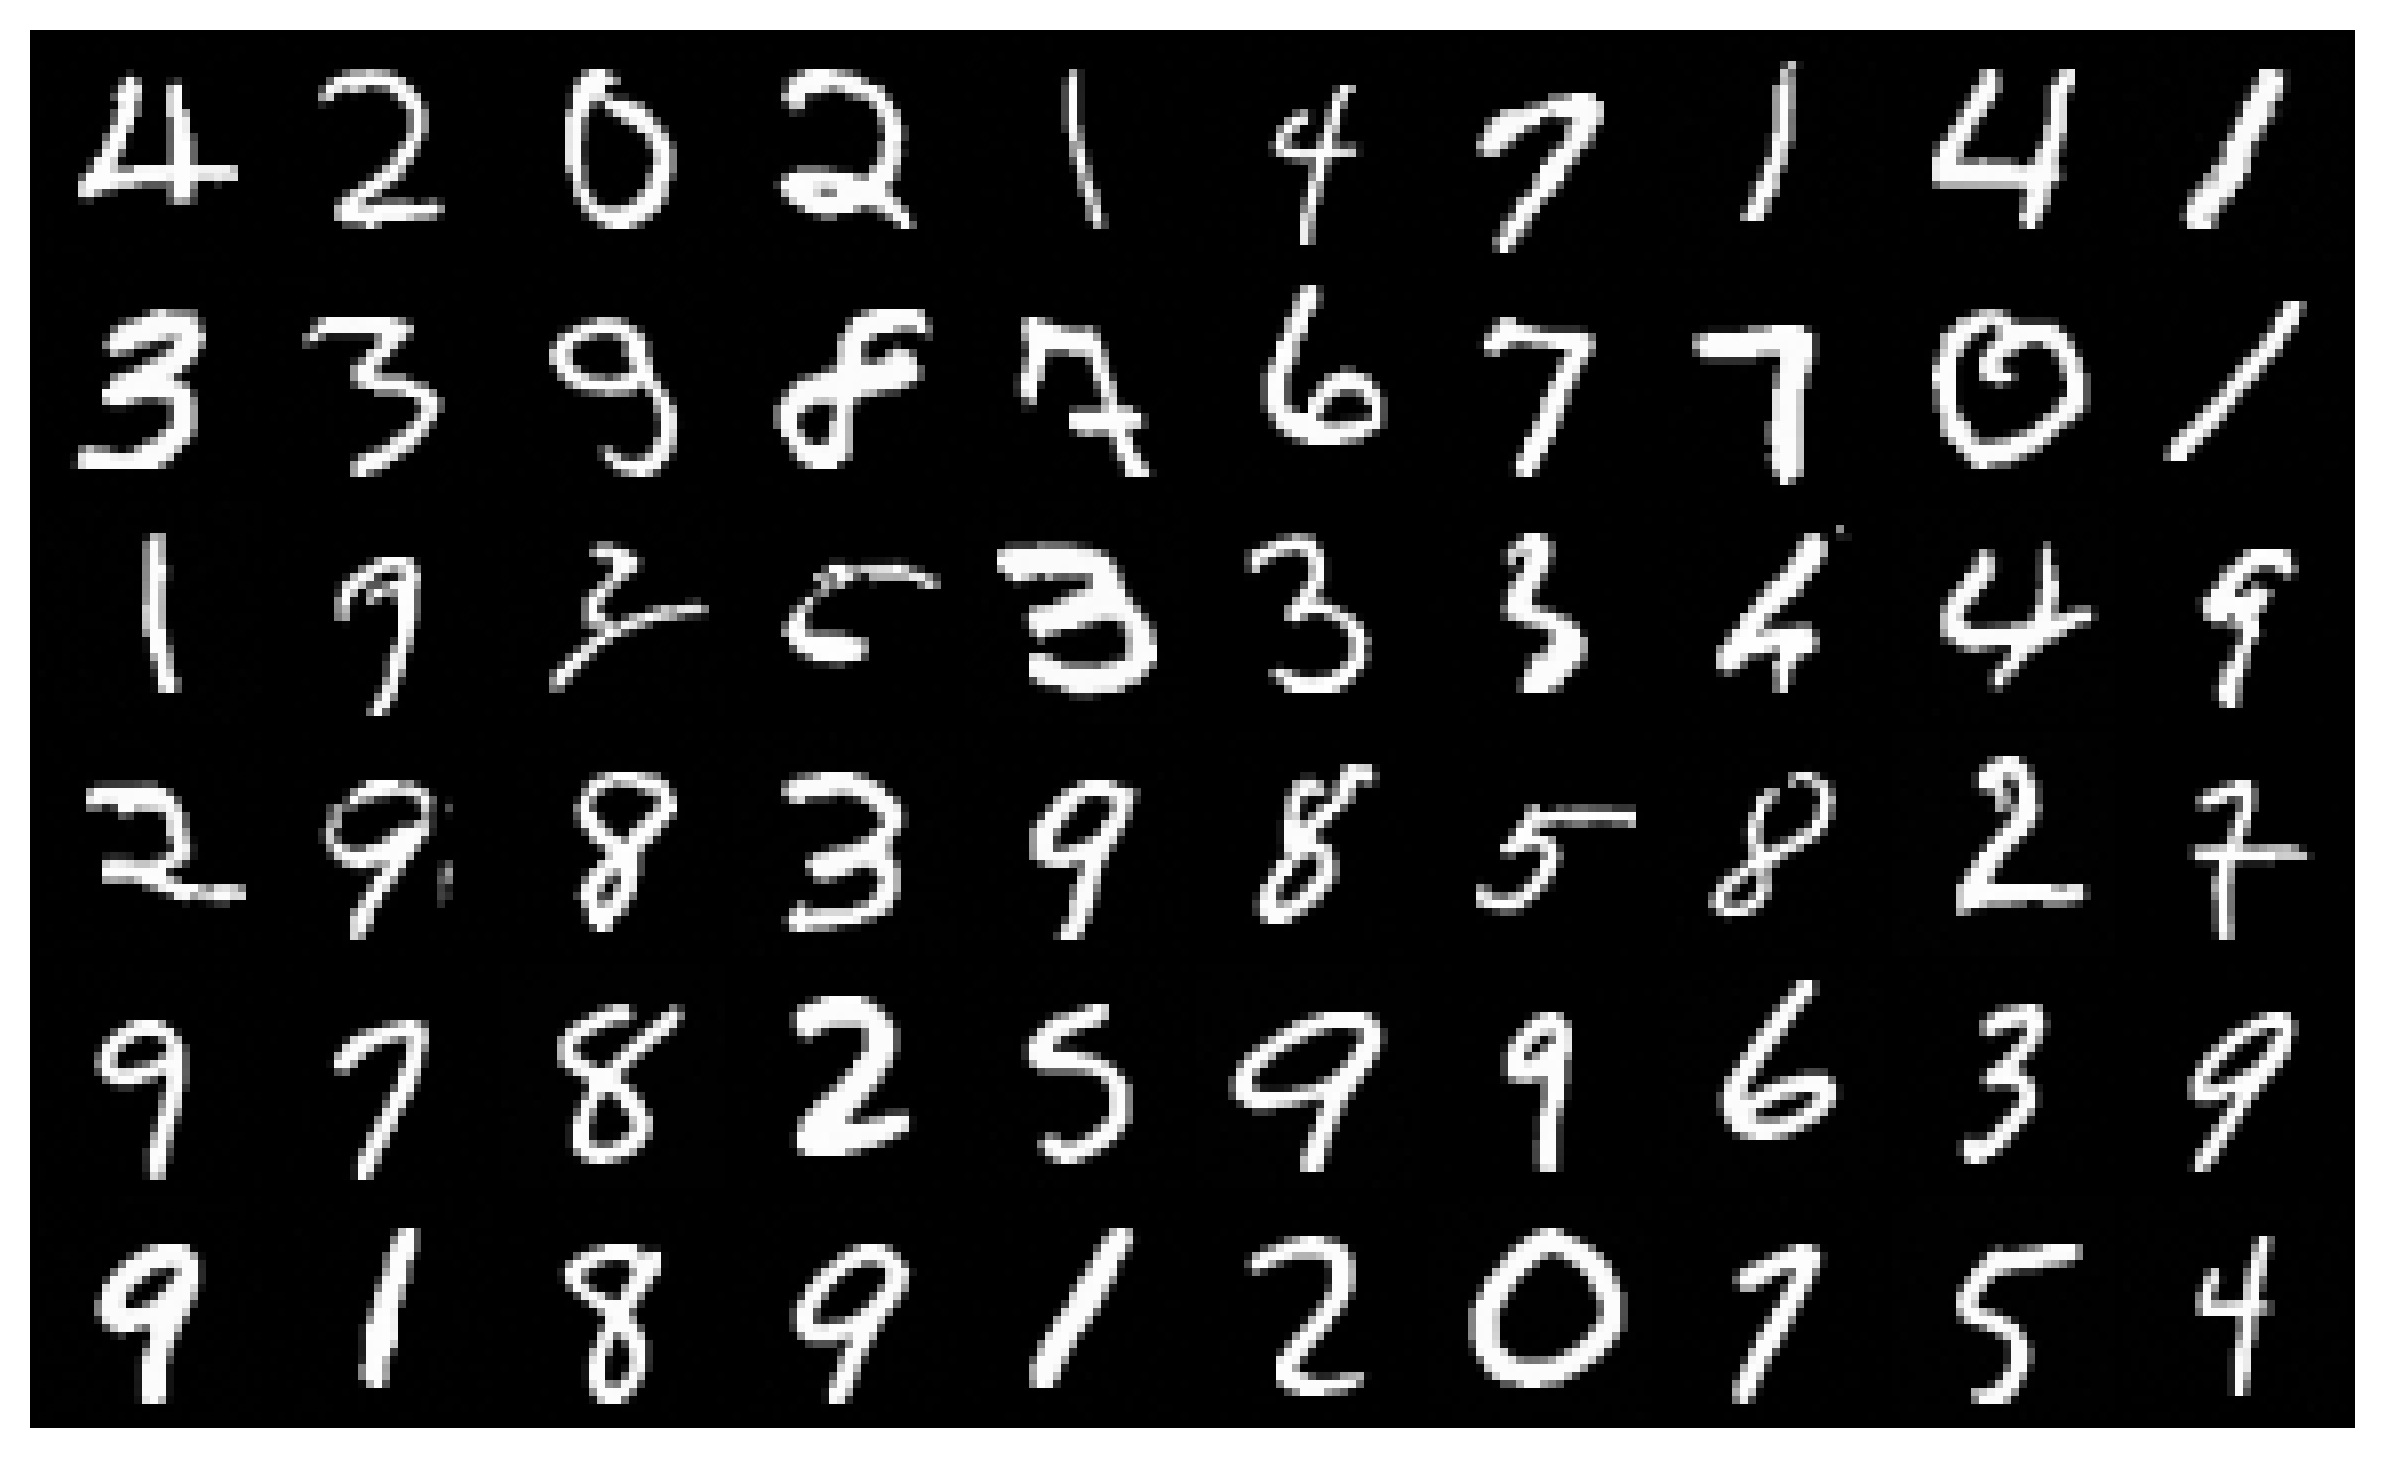

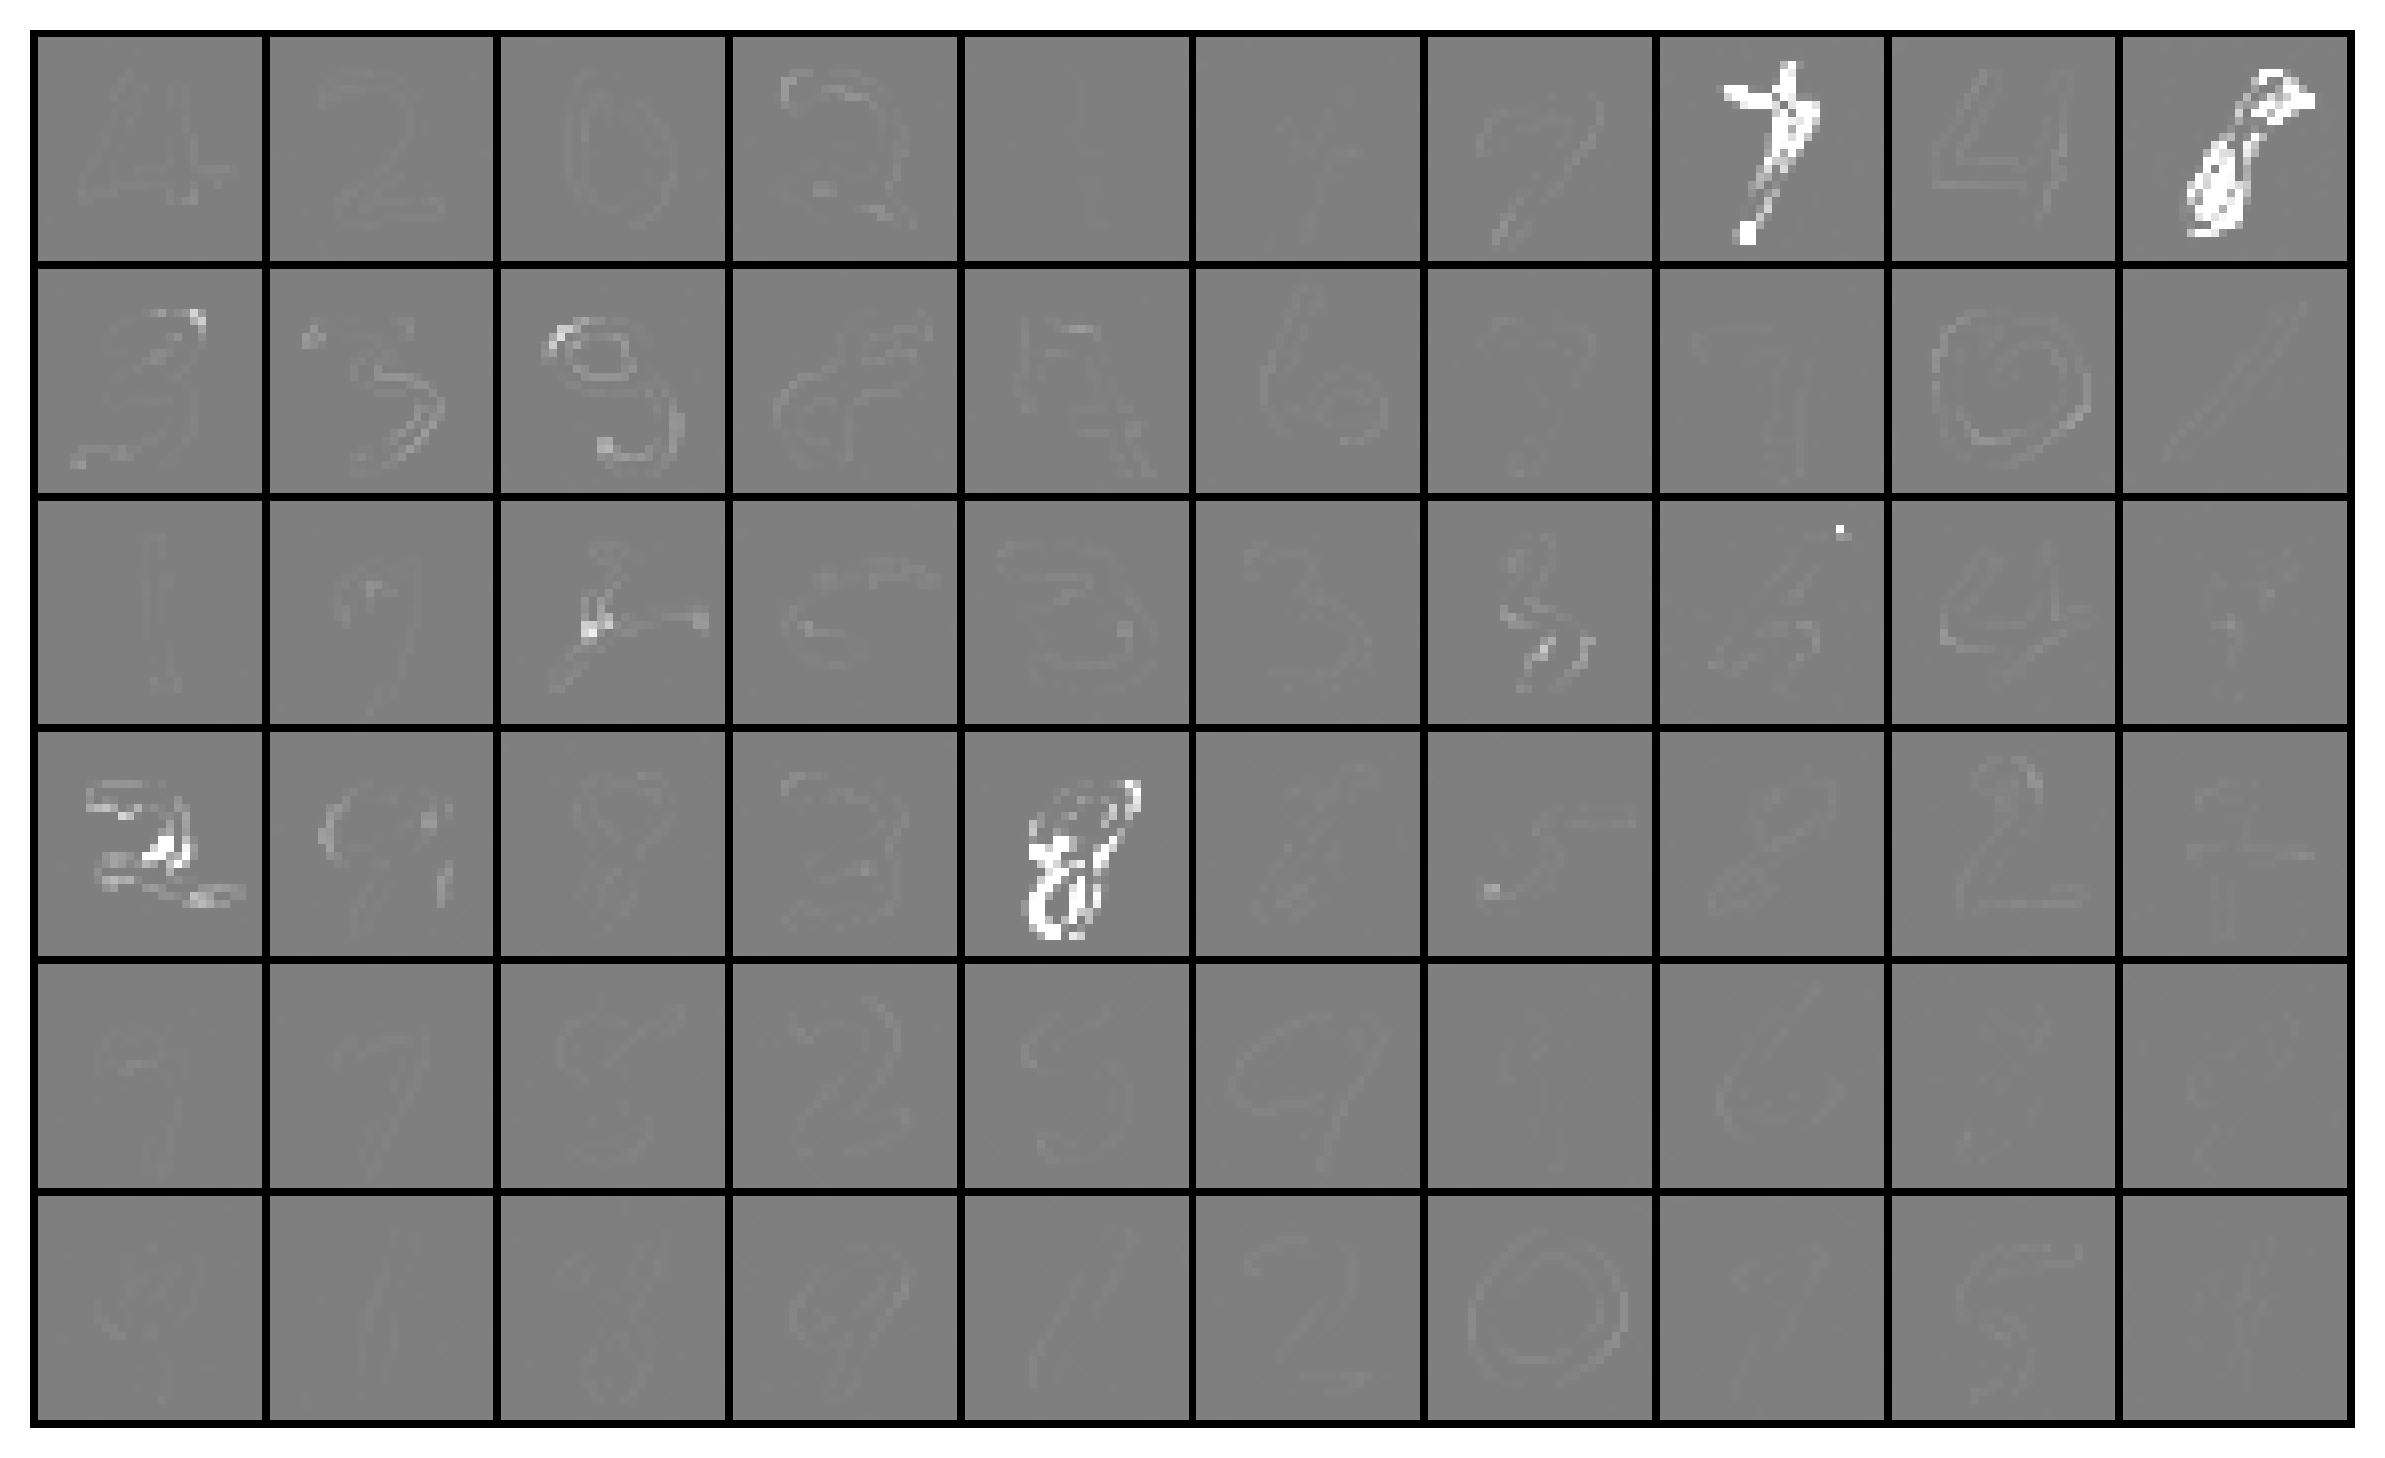

In [8]:
x_eval = batch[0].to(device)[:20]
x_eval = torch.cat([x_eval, rf_samples[:20], rf_sde_samples[:20]], dim=0)
alpha = 0.005
x_eval = (1. - alpha) * x_eval + alpha * torch.randn_like(x_eval)
# x_eval = x_1
N = 300
plot_cifar_results(x_eval)

# Generate an ODE trajectory for evaluation
time_grid = torch.linspace(0., 1. - alpha, N, device=device)
inv_rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=lambda x, t: -flow_model(x, 1. - t),
    device=device,
)
sampler_inv = EulerSampler(rectified_flow=inv_rf, time_grid=time_grid)
x_0_inv = sampler_inv.sample_loop(x_0=x_eval).trajectories[-1]
plot_cifar_results(x_0_inv)

# Now generate samples from x_0_inv back to x_eval, to see how well we reconstruct
rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=flow_model,
    device=device,
)
sampler = EulerSampler(rectified_flow=rf, num_samples=50, num_steps=N)
x_1 = sampler.sample_loop(x_0=x_0_inv).trajectories[-1]
plot_cifar_results(x_1)
plot_cifar_results(torch.abs(x_1 - x_eval))

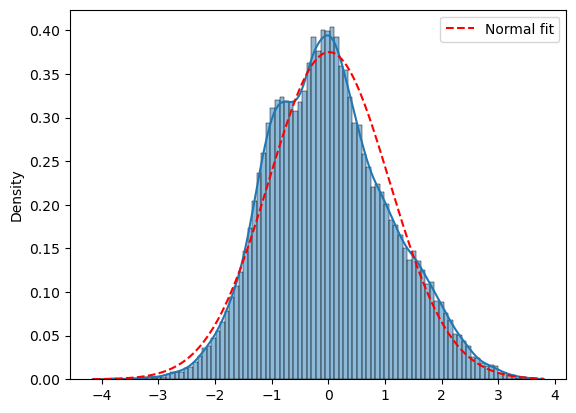

In [9]:
import seaborn as sns
import scipy.stats as stats

x = x_0_inv.view(-1).cpu().numpy()
sns.histplot(x, kde=True, stat="density")
mu, sigma = x.mean(), x.std()
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), 'r--', label='Normal fit')
plt.legend()
plt.show()

In [10]:
def standard_normal_logprob(z):
    B = z.shape[0]
    zf = z.view(B, -1)
    D = zf.shape[1]
    return -0.5 * (zf.pow(2).sum(dim=1) + D * math.log(2 * math.pi))

def estimate_logprob_from_inverse(
    x_0_inv: torch.Tensor,
    rf,                      
    flow_model,
    N: int = 300,
    alpha: float = 0.0,       
    sample_stride: int = 5,
):
    device = x_0_inv.device
    B = x_0_inv.shape[0]

    t1 = max(0.0, 1.0 - alpha)
    time_grid = torch.linspace(0., t1, N, device=device)

    sampler_fwd = EulerSampler(rectified_flow=rf, time_grid=time_grid)
    traj = sampler_fwd.sample_loop(x_0=x_0_inv).trajectories
    states = torch.stack(traj, dim=0) if isinstance(traj, list) else traj     # (T, B, C, H, W)
    T = states.shape[0]

    idx = torch.arange(0, T, sample_stride, device=device)
    if idx[-1].item() != T - 1:
        idx = torch.cat([idx, torch.tensor([T - 1], device=device)])
    t_used = time_grid.index_select(0, idx)               # (Ts,)
    x_used = states.index_select(0, idx)                  # (Ts, B, C, H, W)

    div_values = []
    for k in tqdm(range(t_used.shape[0]), desc="Computing divergences"):
        tk = t_used[k]
        xk = x_used[k]                                     # (B, C, H, W)
        tb = torch.full((B,), tk.item(), device=device)    # (B,)
        div_k = divergence_hutchinson(flow_model, xk, tb)  # (B,)
        div_values.append(div_k)
    divs = torch.stack(div_values, dim=0)                  # (Ts, B)

    int_div = torch.trapz(divs, t_used, dim=0)            # (B,)
    log_rho0 = standard_normal_logprob(x_0_inv)           # (B,)
    log_rho_eval = log_rho0 - int_div                     # (B,)

    details = {
        "time_grid_full": time_grid,   # (T,)
        "time_grid_used": t_used,      # (Ts,)
        "states_used": x_used,         # (Ts, B, C, H, W)
        "divergences": divs,           # (Ts, B)
        "int_divergence": int_div,     # (B,)
        "log_rho0": log_rho0,          # (B,)
    }
    return log_rho_eval, details

log_rho_eval, details = estimate_logprob_from_inverse(
    x_0_inv=x_0_inv,
    rf=rf,
    flow_model=flow_model,
    N=300,
    alpha=0.0,
    sample_stride=5,
)

Computing divergences: 100%|██████████| 61/61 [00:24<00:00,  2.45it/s]


In [11]:
print("Train Set logp mean",log_rho_eval[:20].mean())

print("ODE logp mean",log_rho_eval[20:40].mean())

print("SDE logp mean",log_rho_eval[40:60].mean())

Train Set logp mean tensor(2559.8367, device='cuda:0')
ODE logp mean tensor(2531.2495, device='cuda:0')
SDE logp mean tensor(2617.9705, device='cuda:0')


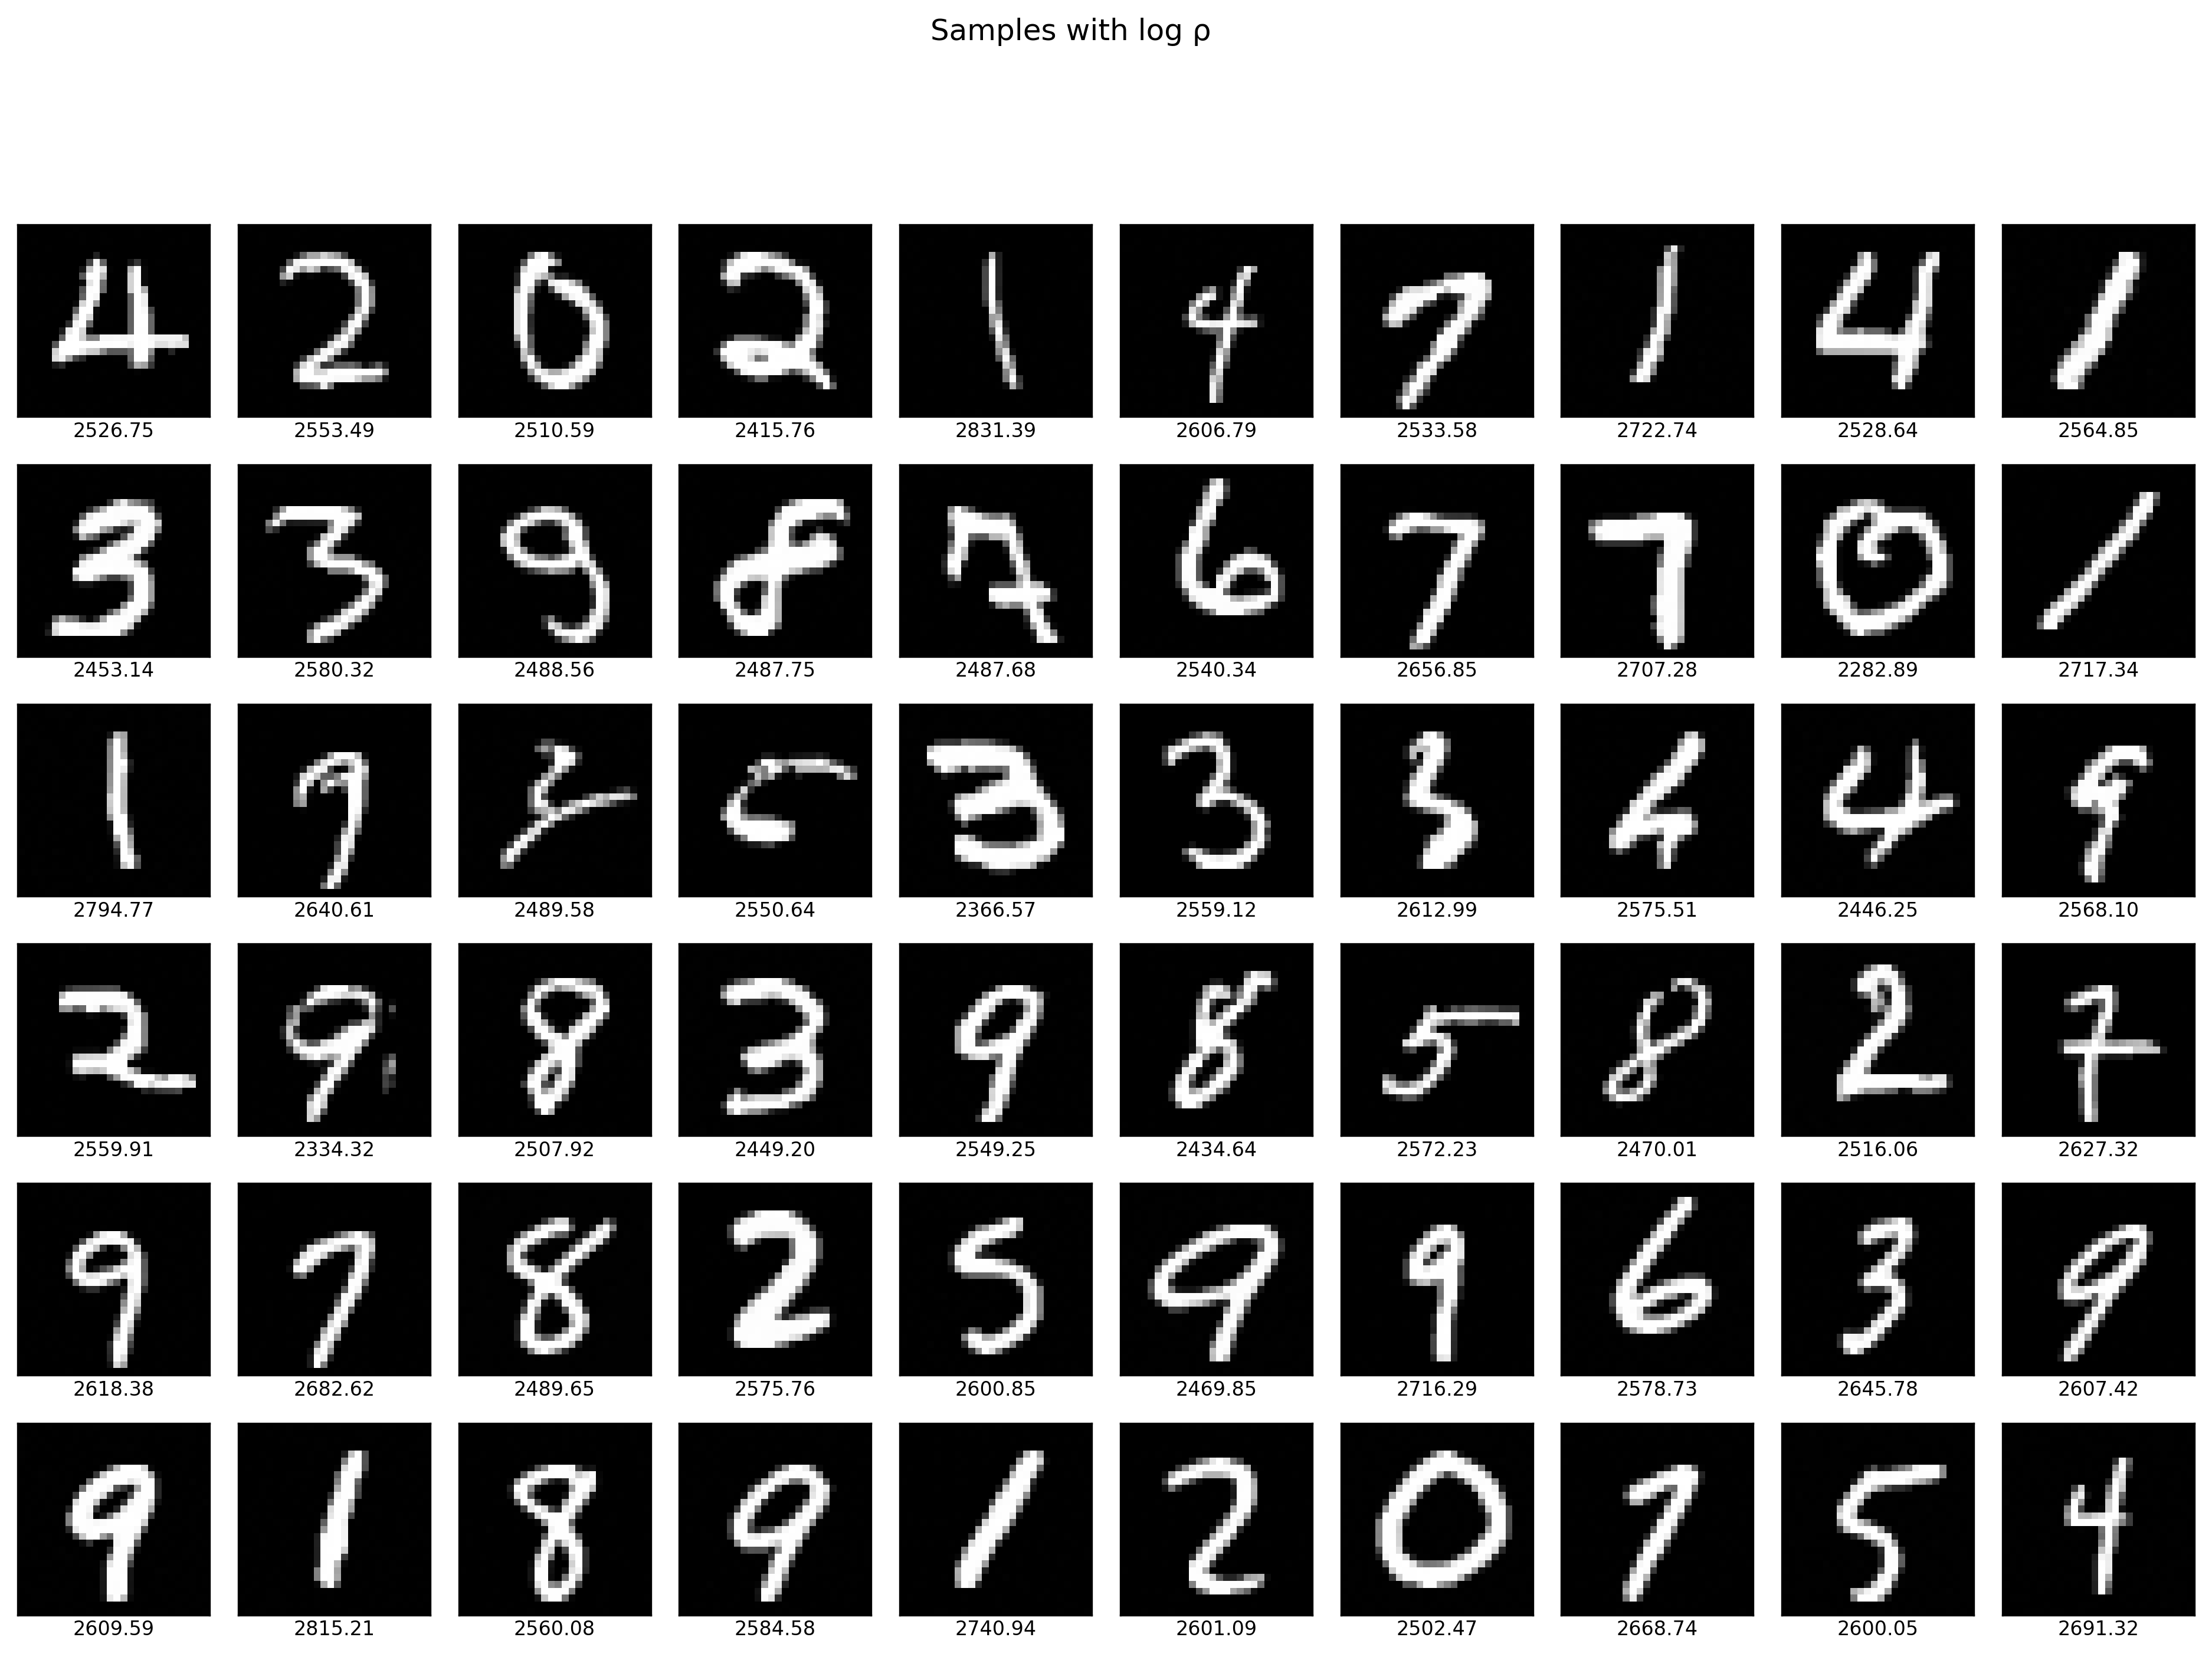

In [12]:
@torch.no_grad()
def plot_images_with_logrho(
    images: torch.Tensor,
    log_rho: torch.Tensor,
    nrow: int = 10,
    title: str | None = None,
    digits: int = 2,
    dpi: int = 300,
    fontsize: int = 8,
    normalize_from_neg1_pos1: bool = True,
    save_path: str | None = None,
):
    assert images.ndim == 4, "images should be (B, C, H, W)"
    B = images.shape[0]
    cols = min(nrow, B)
    rows = math.ceil(B / cols)

    imgs = images.detach().cpu().clone()
    if normalize_from_neg1_pos1:
        imgs = (imgs * 0.5 + 0.5).clamp(0, 1)

    scores = log_rho.detach().cpu().view(-1)

    fig_w = cols * 1.6
    fig_h = rows * 1.7
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), dpi=dpi)
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.ravel()

    for i in range(rows * cols):
        ax = axes[i]
        if i < B:
            img = imgs[i]
            # (C,H,W) -> (H,W,C)；灰度图兼容
            if img.shape[0] == 1:
                ax.imshow(img.squeeze(0), cmap="gray")
            else:
                ax.imshow(img.permute(1, 2, 0).numpy())
            ax.set_xticks([]); ax.set_yticks([])
            # 在图片下方标注 log_rho
            label = f"{scores[i].item():.{digits}f}"
            ax.set_xlabel(label, fontsize=fontsize, labelpad=2)
            ax.xaxis.set_label_position('bottom')
        else:
            ax.axis("off")

    if title is not None:
        fig.suptitle(title, fontsize=12, y=0.995)

    plt.subplots_adjust(wspace=0.05, hspace=0.25)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.1)
    plt.show()

plot_images_with_logrho(
    images=details["states_used"][-1],
    log_rho=log_rho_eval[:60],
    nrow=10,
    title="Samples with log ρ",
    digits=2,
    dpi=300,
    fontsize=8,
)